In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from pandas import DataFrame, Series
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

rfc = RandomForestRegressor()
xgb = XGBRegressor()
lr = LinearRegression()
lgbm = LGBMRegressor()
svc = LinearSVC()

In [59]:
y = pd.read_csv('./y_open_0905~_1000(5min)/y_open_0930.csv', index_col=0)
X = pd.read_csv('./X_Features.csv')


In [60]:

from datetime import datetime

# 시간 형태로 변경
X['date'] = pd.to_datetime(X['date'] ,format="%Y-%m-%d")
y['date'] = pd.to_datetime(y['date'],format= "%Y%m%d")

# merge X, y
df = pd.merge(X,y, on='date',how='inner')
df.sort_index(inplace=True)

# y의 시점 변환
df['open']=df['open'].shift(-1)

# index = date
df.set_index('date', inplace=True)
df.dropna(inplace=True)

# X, y 정의
y = df[['open']]
y.rename(columns={'open' : "target"})
X = df.drop(columns='open')

In [61]:
X_scaled = X.drop(['kodex_close','PBR','kodex_high','KODEX_return','kosdaq_open','kosdaq_high','WTI_RETURN','krx_close','Dividend_Yield','kosdaq_volume','VIX_RETURN','kosdaq_close','kosdaq_low','kodex_low','USA_3Y','MEAL_RETURN','USA_10Y','GOLD_RETURN','krx_diff','BTC_RETURN','kodex_open','KR_3Y','KR_10Y','kodex_volume'],axis=1)

# OLS 정보 보기 
feature_add = sm.add_constant(X_scaled, has_constant='add')
# sm OLS 적합
model = sm.OLS(y , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   open   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     52.93
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.07e-49
Time:                        15:25:10   Log-Likelihood:                -11929.
No. Observations:                1199   AIC:                         2.387e+04
Df Residuals:                    1193   BIC:                         2.390e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              2.98e+04   1269.460     23.476      0.000    2.73e+04    3.23e+04
krx_return        -635.0829   2273.312     -0.279      0.780   -5095.217    3825.051
PER               8478.9319    527.396     16.077      0.000    7444.206    9513.658
SP_500_RETURN     3905.3754   1732.939      2.254      0.024     505.428    7305.322
USD_KRW_RETURN   -1881.0477   1439.219     -1.307      0.191   -4704.729     942.634
Kosdaq150_return -3795.3398   2232.603     -1.700      0.089   -8175.605     584.926
==============================================================================
Omnibus:                      951.529   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.516
Skew:                           0.097   Prob(JB):                     6.59e-17
Kurtosis:                       1.794   Cond. No.                         29.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Index(['krx_return', 'PER', 'SP_500_RETURN', 'USD_KRW_RETURN',
       'Kosdaq150_return'],
      dtype='object')

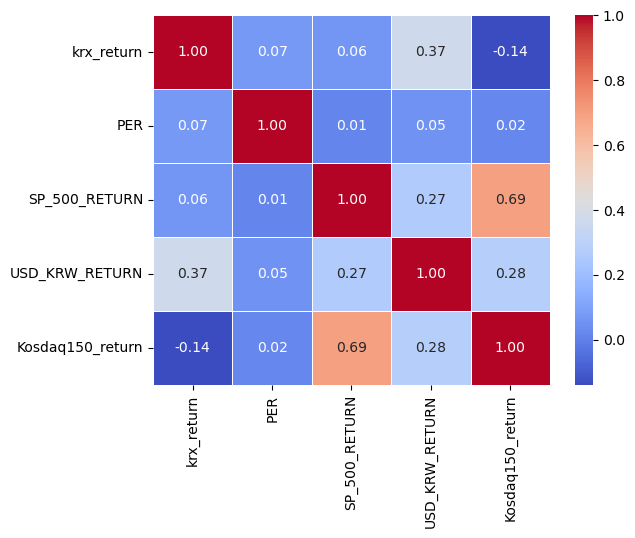

In [62]:
sns.heatmap(X_scaled.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
X_scaled.columns

In [63]:
df1 = df[['open','krx_return', 'PER', 'SP_500_RETURN', 'USD_KRW_RETURN', 'kodex_close','Kosdaq150_return']]
np.abs(df1.corr()['open']).sort_values(ascending=False)

open                1.000000
kodex_close         0.998848
PER                 0.420121
SP_500_RETURN       0.033451
krx_return          0.022558
USD_KRW_RETURN      0.018762
Kosdaq150_return    0.010836
Name: open, dtype: float64

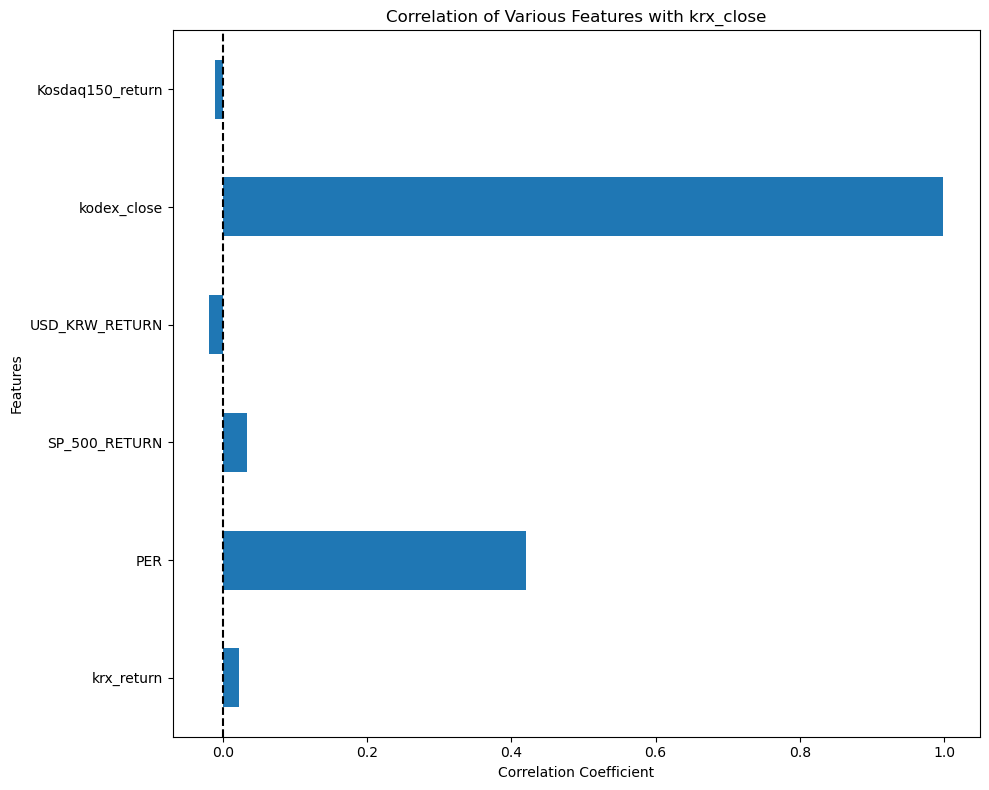

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Extract the 'krx_close' column's correlation values
krx_close_correlations = correlation_matrix['open'].drop('open')  # drop self-correlation

# Plot a horizontal bar chart for the 'krx_close' correlations
plt.figure(figsize=(10, 8))
krx_close_correlations.plot(kind='barh')  # Change to horizontal bar chart
plt.title('Correlation of Various Features with krx_close')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='k', linestyle='--')  # Add a vertical line at zero
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [65]:
# Select only numeric columns (excluding 'open' which is the target variable)
numeric_cols = df1.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('open')  # Remove the target variable from the list

# Calculate VIF for each feature
VIF_data = pd.DataFrame()
VIF_data['feature'] = numeric_cols
VIF_data['VIF'] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(len(numeric_cols))]

# Display the VIF values
VIF_data.sort_values(by='VIF', ascending=False)


,feature,VIF
1,PER,7.977782
4,kodex_close,7.954318
5,Kosdaq150_return,2.216089
2,SP_500_RETURN,2.030430
3,USD_KRW_RETURN,1.334083
0,krx_return,1.311640


In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df1, threshold=10):

    features = df1.select_dtypes(include=[np.number]).columns.tolist()
    features.remove('open')  # Remove the target variable
    
    high_vif_features = []
    while True:
        # Calculate VIF for remaining features
        VIF_df = pd.DataFrame()
        VIF_df['feature'] = features
        VIF_df['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
        
        # Find the feature with the maximum VIF
        max_vif = VIF_df['VIF'].max()
        
        if max_vif > threshold:
            # Find the feature with the highest VIF and remove it
            feature_to_remove = VIF_df[VIF_df['VIF'] == max_vif]['feature'].values[0]
            features.remove(feature_to_remove)
            high_vif_features.append(feature_to_remove)
        else:
            # When all VIF values are below the threshold, break the loop
            break
    
    # Return the reduced DataFrame and the list of removed features
    df_reduced = df.drop(columns=high_vif_features)
    return df_reduced, high_vif_features

# Use the function on the joined_df_cleaned DataFrame
reduced_df, removed_features = calculate_vif(df1)


In [67]:
df1

,open,krx_return,PER,SP_500_RETURN,USD_KRW_RETURN,kodex_close,Kosdaq150_return
date,,,,,,,
2018-10-01,27112.0,-0.11,10.18,-2,0.0,27099,-24.0
2018-10-02,26613.0,-1.21,10.05,0,-8.0,26770,58.0
2018-10-04,26388.0,-1.60,9.89,-18,-14.0,26356,-43.0
2018-10-05,26280.0,-0.17,9.87,-17,-7.0,26316,-9.0
2018-10-08,26199.0,-0.47,9.83,7,-1.0,26185,9.0
...,...,...,...,...,...,...,...
2023-10-19,31980.0,-1.84,16.38,-43,-3.0,32430,-180.0
2023-10-20,31845.0,-1.49,16.14,-49,6.0,31940,-35.0
2023-10-23,31810.0,-0.77,16.01,7,15.0,31770,125.0


In [68]:
removed_features

[]

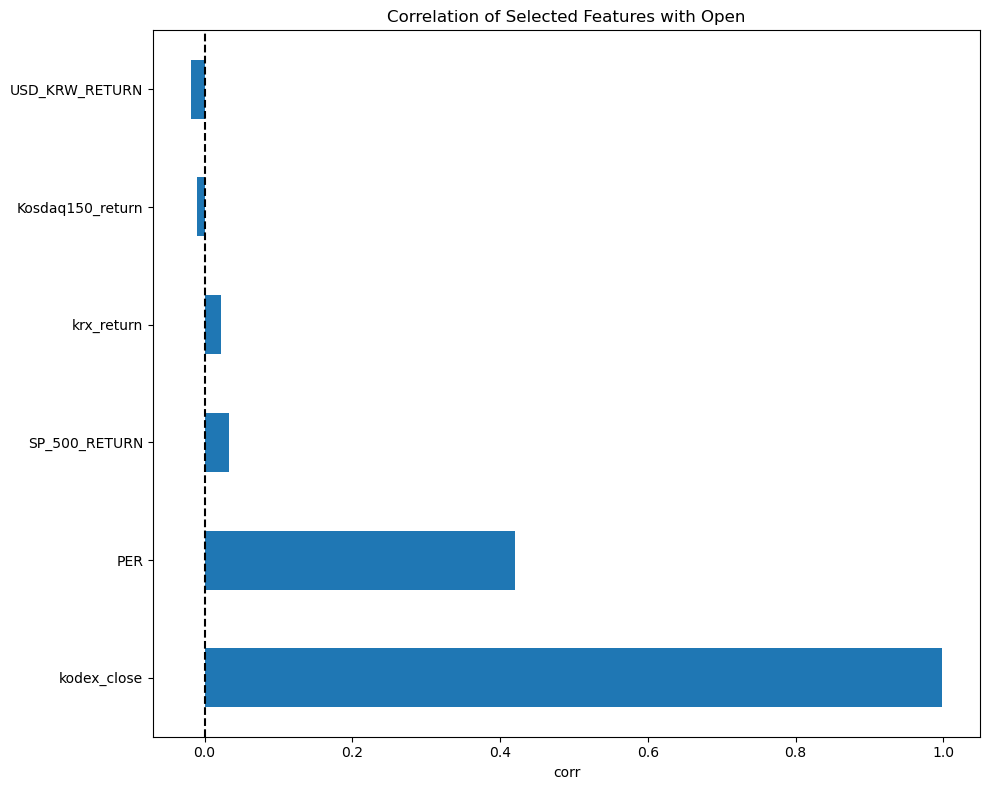

In [69]:
# 상관 계수 행렬 계산: 'open'을 포함한 감소된 데이터프레임
correlation_matrix_reduced_kor = df1.corr()

# 'open'과의 상관관계 추출 및 정렬
open_correlations_kor = correlation_matrix_reduced_kor['open'].drop('open').sort_values(ascending=False)

# 'open'과의 상관관계에 대한 바 차트 그리기
plt.figure(figsize=(10, 8))
open_correlations_kor.plot(kind='barh')
plt.title('Correlation of Selected Features with Open')
plt.xlabel('corr')
plt.axvline(x=0, color='k', linestyle='--')  # 0에 수직선 추가
plt.tight_layout()  # 레이아웃 조정

# 그래프 표시
plt.show()


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# X와 y 정의
X = df1.drop('open', axis=1)
y = df1[['open']]

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# StandardScaler객체 생성
scaler = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 모델
linear_regression_model = LinearRegression()

# Fit model
linear_regression_model.fit(X_train, y_train)

# Predict test
y_pred = linear_regression_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

mse, rmse , r2


(31542.703662324897, 177.60265668712532, 0.986930714910591)

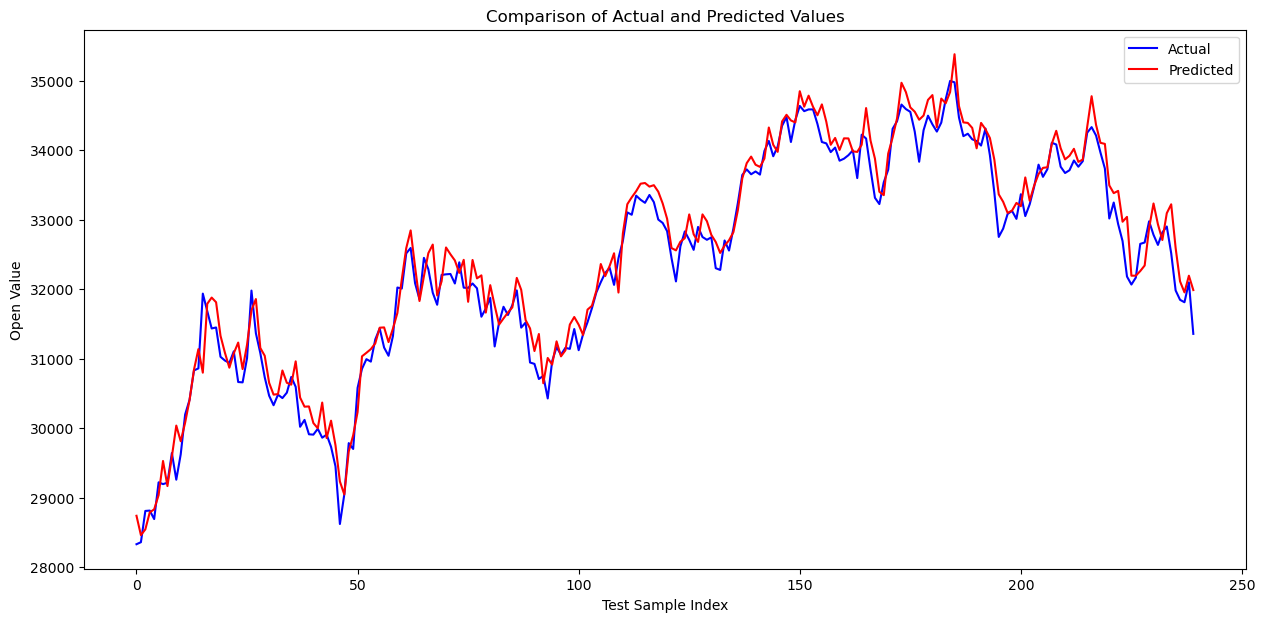

In [79]:
import matplotlib.pyplot as plt

# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test, label='Actual', color='blue')
plt.plot(test_indices, y_pred.flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


### 너무 낮은 성능 -> 시기를 섞어보자

In [93]:
# X와 y 정의
X = reduced_df.drop('open', axis=1)
y = reduced_df['open']

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델
linear_regression_model = LinearRegression()

# Fit model
linear_regression_model.fit(X_train, y_train)

# Predict test
y_pred = linear_regression_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(20762342.54156116, 0.34308496647945497)

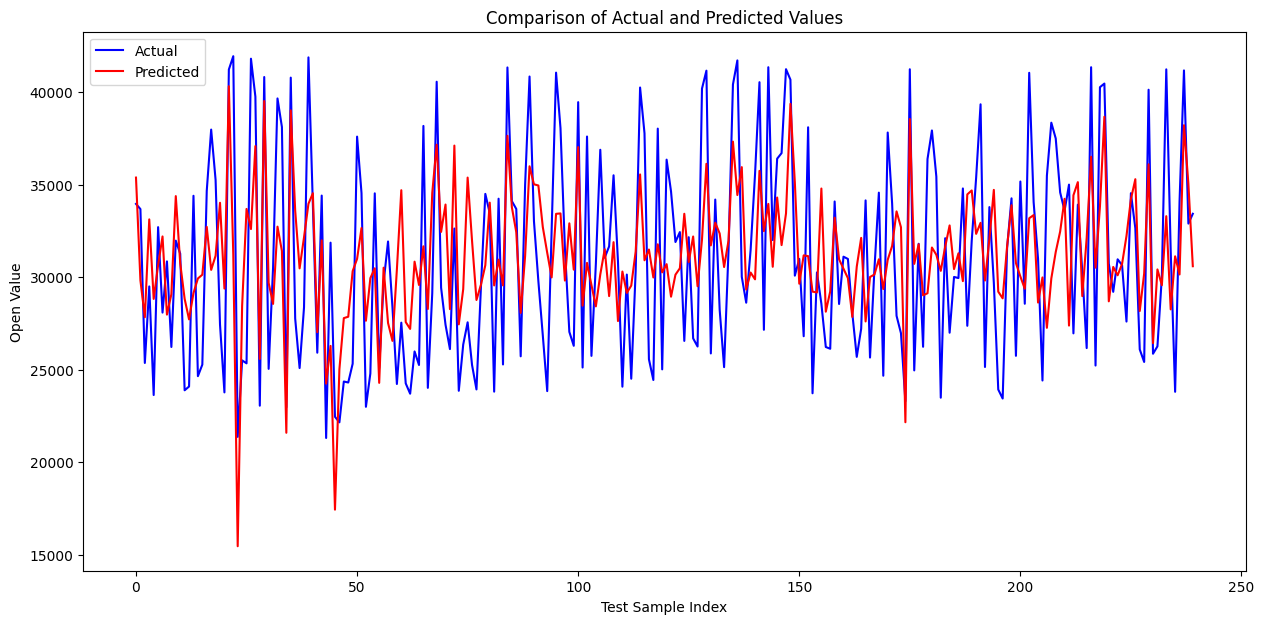

In [94]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test, label='Actual', color='blue')
plt.plot(test_indices, y_pred.flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


### 0.34의 변동을 설명, 모델이 설명할 수 있게 되었지만 아쉬운 성능
#### 1. 시기 분리

In [95]:
# 데이터셋을 다시 로드하고, 'date' 컬럼을 datetime으로 변환한 후 인덱스로 설정합니다.
reduced_df = reduced_df.reset_index()
reduced_df['date'] = pd.to_datetime(reduced_df['date'])
reduced_df.set_index('date', inplace=True)

# 연도별로 데이터프레임을 분리합니다.
years = reduced_df.index.year.unique()  # 연도별로 유니크한 값을 추출합니다.
yearly_dfs = {year: reduced_df[reduced_df.index.year == year] for year in years}  # 연도별 데이터프레임을 생성합니다.

# 2023년 데이터프레임을 예로 들어 확인해 봅니다.
yearly_dfs[2023].head(10)  # 2023년 데이터프레임의 처음 몇 행을 출력합니다.



,krx_diff,PER,GOLD_RETURN,MEAL_RETURN,SP_500_RETURN,USD_KRW_RETURN,VIX_RETURN,WTI_RETURN,BTC_RETURN,USA_3Y,kodex_volume,kosdaq_volume,KODEX_return,Kosdaq150_return,open
date,,,,,,,,,,,,,,,
2023-01-03,-0.21,9.31,14.3,-10.50,-29,-18.0,-0.19,-3.54,-9000.0,4.156,9429624,12479514,-162.0,-90.0,29046.0
2023-01-04,6.40,9.51,13.8,-35.00,12,-1.0,-0.92,-4.31,21000.0,4.110,8244362,11823207,167.0,0.0,29783.0
2023-01-05,1.89,9.57,-20.6,0.75,-31,5.0,0.26,0.41,-32000.0,4.210,8290777,9131020,-206.0,-60.0,29699.0
2023-01-06,3.66,9.69,33.8,-5.00,72,18.0,-1.56,-0.14,156000.0,3.985,7506914,9713387,334.0,110.0,30578.0
2023-01-09,8.16,9.95,5.0,-6.50,-18,35.0,0.22,1.05,-26000.0,3.948,8083754,9149776,-84.0,-44.0,30853.0
2023-01-10,-0.12,9.95,0.8,-10.25,31,14.0,-1.64,0.21,178000.0,3.982,7641179,6338292,138.0,100.0,30991.0
2023-01-11,0.81,9.98,-2.4,9.75,37,-3.0,0.29,2.62,517000.0,3.920,6137182,8160934,187.0,85.0,30956.0
2023-01-12,0.32,9.99,19.1,3.75,6,2.0,-2.73,0.75,834000.0,3.811,5541541,7228509,78.0,0.0,31275.0
2023-01-13,3.07,10.09,22.9,0.25,39,5.0,-0.65,1.53,1218000.0,3.889,6372053,6856334,59.0,-10.0,31433.0


In [96]:
# X와 y 정의
X = yearly_dfs[2020].drop('open', axis=1)
y = yearly_dfs[2020]['open']

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False, random_state=42)

# 모델
linear_regression_model = LinearRegression()

# Fit model
linear_regression_model.fit(X_train, y_train)

# Predict test
y_pred = linear_regression_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(9729782.625036214, -0.6076319378669097)

In [97]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8624991284774697893
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2249719808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7833065692116402257
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:06:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [98]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# X와 y 정의
X = reduced_df.drop('open', axis=1)
y = reduced_df['open']

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False, random_state=42)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞는 데이터 형태로 변환: [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM 모델 설계
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# 성능 평가
predicted = model.predict(X_test_scaled)
mse_lstm = mean_squared_error(y_test, predicted)
r2_lstm = r2_score(y_test, predicted)

mse_lstm, r2_lstm


Epoch 1/100
30/30 [==============================] - 3s 31ms/step - loss: 998533248.0000 - val_loss: 1048578752.0000
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 998454848.0000 - val_loss: 1048399808.0000
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 998194496.0000 - val_loss: 1048054080.0000
Epoch 4/100
30/30 [==============================] - 0s 7ms/step - loss: 997907584.0000 - val_loss: 1047828672.0000
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 997732096.0000 - val_loss: 1047686912.0000
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 997608192.0000 - val_loss: 1047571648.0000
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 997502528.0000 - val_loss: 1047468096.0000
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 997405376.0000 - val_loss: 1047371072.0000
Epoch 9/100
30/30 [==============================] - ETA: 0s - loss: 9

KeyboardInterrupt: 